In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

## Load and Preprocess Data

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [3]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
del data

In [4]:
# Only keep samples with current profiles that exceed 1 kA
filtered = [(s, current) for s, current in currents if current.max() > 1000]
len(filtered)

20335

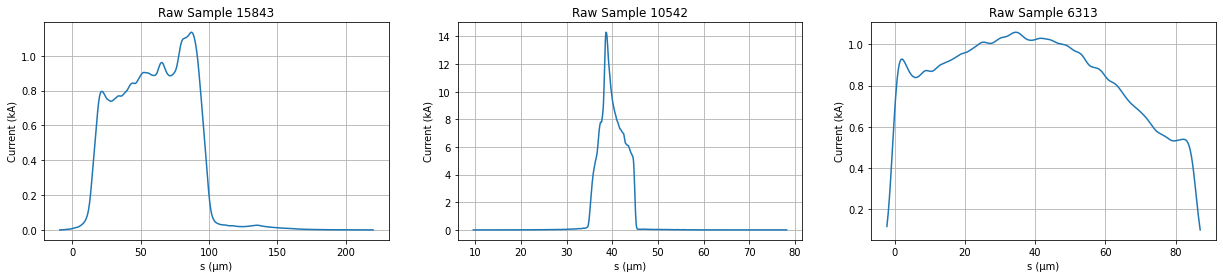

In [5]:
samples = np.random.randint(0, len(filtered), size=3)

plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = filtered[sample][0]
    current = filtered[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Raw Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.show()

In [6]:
# Shift center of mass of each current profile onto the origin

def shift_onto_center_of_mass(s, current):
    """Shift a current profile such that its center of mass it at 0."""
    cm = (s * current).sum() / current.sum()
    return s - cm, current

shifted = [shift_onto_center_of_mass(s, current) for s, current in filtered]

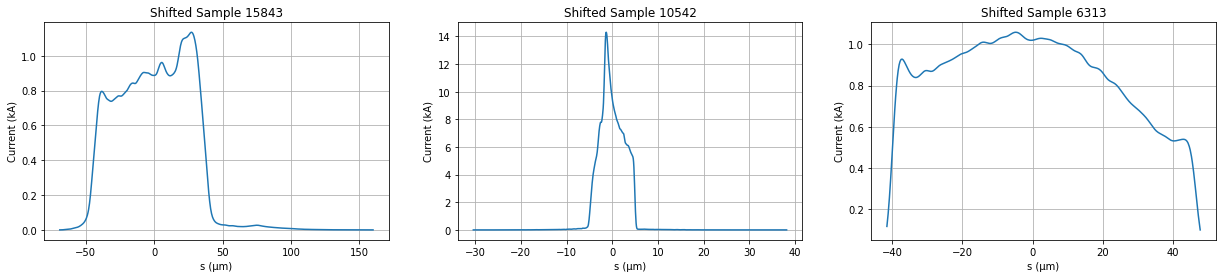

In [7]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = shifted[sample][0]
    current = shifted[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Shifted Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.show()

In [8]:
# Find longitudinal edges

def find_edges(s, current, threshold=0.05):
    filtered = uniform_filter1d(current, size=5, mode="nearest")

    half_values, = np.where(filtered >= threshold * filtered.max())
    left = s[half_values[0]]
    right = s[half_values[-1]]
    
    return left, right

edges = [find_edges(*current, threshold=0.02) for current in shifted]

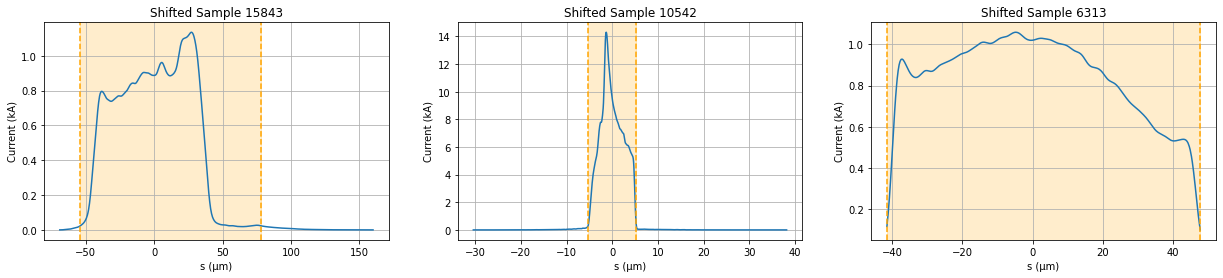

In [9]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = shifted[sample][0]
    current = shifted[sample][1]
    left, right = edges[sample]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Shifted Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.axvspan(left*1e6, right*1e6, color="orange", alpha=0.2)
    plt.axvline(left*1e6, color="orange", ls="--")
    plt.axvline(right*1e6, color="orange", ls="--")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.show()

In [10]:
# Interpolate current profiles into 100 samples within their edges

def interpolate_into_edges(s, current, left, right):
    new_s = np.linspace(left, right, 100)
    new_current = np.interp(new_s, s, current, left=0, right=0)
    
    return new_s, new_current

interpolated = [interpolate_into_edges(*current, *edge) for current, edge in zip(shifted, edges)]

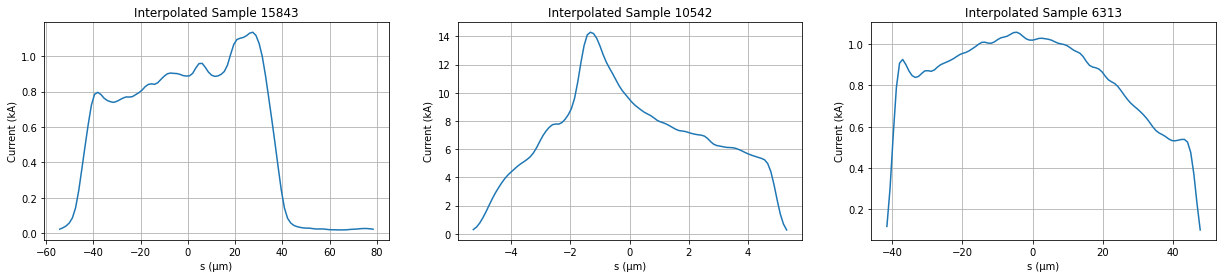

In [11]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = interpolated[sample][0]
    current = interpolated[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Interpolated Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.show()

In [12]:
# Make formfactors

def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors = np.array([current2formfactor(*current, grating="both") for current in filtered])
# formfactors_low = np.array([current2formfactor(*current, grating="low") for current in filtered])
# formfactors_high = [current2formfactor(*current, grating="high") for current in filtered]

/usr/local/Caskroom/miniconda/base/envs/spectral-vd/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


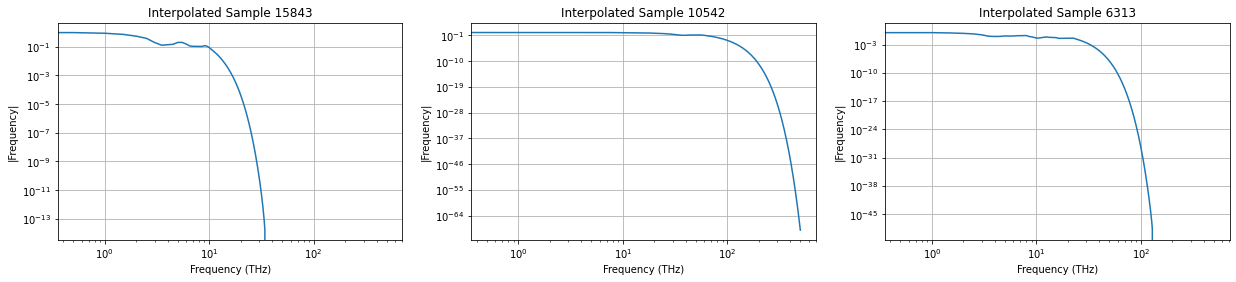

In [13]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    frequency = formfactors[sample][0]
    ff = formfactors[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Interpolated Sample {sample}")
    plt.loglog(frequency*1e-12, ff, label="Formfactor")
    plt.xlabel("Frequency (THz)")
    plt.ylabel("|Frequency|")
    plt.grid()
plt.show()

## Train Edge Model

In [54]:
X = np.stack([formfactor for _, formfactor in formfactors])
y_edge = np.stack([edge for edge in edges])

In [55]:
X_train, X_test, y_edge_train, y_edge_test = train_test_split(X, y_edge, test_size=0.2, shuffle=True)

In [56]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_edge_scaler = StandardScaler()
y_edge_train_scaled = y_edge_scaler.fit_transform(y_edge_train)

In [57]:
edge_model = keras.Sequential([
    layers.Dense(200, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(50, activation="relu"),
    layers.Dense(y_edge_train.shape[1], activation="relu")]
)
edge_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [58]:
history = edge_model.fit(X_train_scaled, y_edge_train_scaled, epochs=800, batch_size=64, validation_split=0.25, verbose=0)

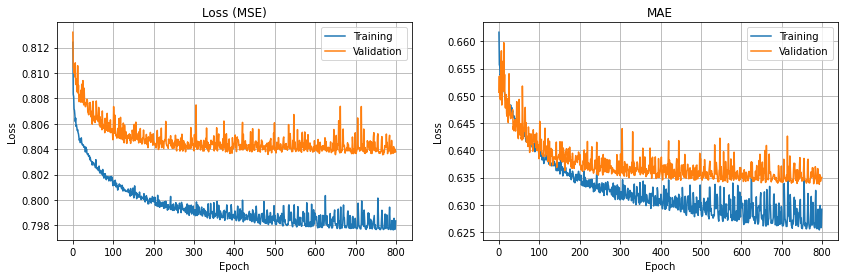

In [59]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.subplot(122)
plt.title("MAE")
plt.plot(history.history["mae"], label="Training")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [61]:
# Evaluate

X_test_scaled = X_scaler.transform(X_test)
y_edge_test_scaled = y_edge_scaler.transform(y_edge_test)

score = edge_model.evaluate(X_test_scaled, y_edge_test_scaled, batch_size=64)

64/64 [==============================] - 0s 3ms/step - loss: 0.7910 - mae: 0.6307


## Train current model

In [62]:
X = np.stack([formfactor for _, formfactor in formfactors])
y_current = np.stack([current for _, current in interpolated])

In [63]:
X_train, X_test, y_current_train, y_current_test = train_test_split(X, y_current, test_size=0.2, shuffle=True)

In [64]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_current_scaler = StandardScaler()
y_current_train_scaled = y_current_scaler.fit_transform(y_current_train)

In [65]:
current_model = keras.Sequential([
    layers.Dense(200, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(50, activation="relu"),
    layers.Dense(y_current_train.shape[1], activation="relu")]
)
current_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [66]:
history = current_model.fit(X_train_scaled, y_current_train_scaled, epochs=800, batch_size=64, validation_split=0.25, verbose=0)

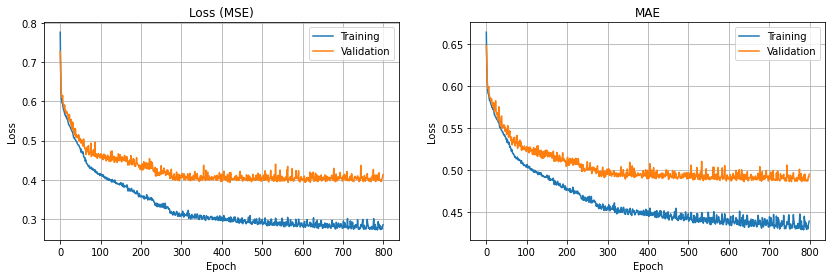

In [67]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.subplot(122)
plt.title("MAE")
plt.plot(history.history["mae"], label="Training")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [68]:
# Evaluate

X_test_scaled = X_scaler.transform(X_test)
y_current_test_scaled = y_current_scaler.transform(y_current_test)

score = current_model.evaluate(X_test_scaled, y_current_test_scaled, batch_size=64)

64/64 [==============================] - 0s 2ms/step - loss: 0.4192 - mae: 0.4982


## Test

In [69]:
X = np.stack([formfactor for _, formfactor in formfactors])[samples]
y_edge = np.stack([edge for edge in edges])[samples]
y_current = np.stack([current for _, current in interpolated])[samples]

In [72]:
X_scaled = X_scaler.transform(X)

y_edge_scaled = edge_model.predict(X_scaled)
y_current_scaled = current_model.predict(X_scaled)

y_edge = y_edge_scaler.inverse_transform(y_edge_scaled)
y_current = y_current_scaler.inverse_transform(y_current_scaled)

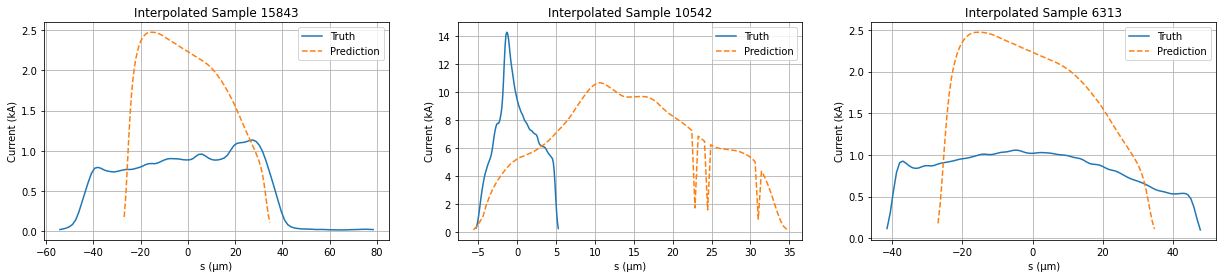

In [74]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    left, right = y_edge[i]
    s_pred = np.linspace(left, right, num=100)
    current_pred = y_current[i]
    
    s = interpolated[sample][0]
    current = interpolated[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Interpolated Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Truth")
    plt.plot(s_pred*1e6, current_pred*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()